In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
from google.colab import files


try:
    # Load the dataset
    file_path = '/content/Metro_Interstate_Traffic_Volume.csv'
    data = pd.read_csv(file_path)

    # Convert date_time to datetime format for potential time series analysis
    data['date_time'] = pd.to_datetime(data['date_time'])

    # Rename Columns for clarity
    data.rename(columns={
        'temp': 'temperature_kelvin',
        'rain_1h': 'rain_mm_per_hour',
        'snow_1h': 'snow_mm_per_hour',
        'clouds_all': 'cloud_coverage_percentage',
        'weather_main': 'weather_condition',
        'weather_description': 'detailed_weather_condition',
        'traffic_volume': 'traffic_volume'
    }, inplace=True)

    # Drop Duplicates
    data.drop_duplicates(inplace=True)

    data['temperature_fahrenheit'] = (data['temperature_kelvin'] - 273.15) * 9/5 + 32
    data.drop('temperature_kelvin', axis=1, inplace=True)  # Remove the original Kelvin column if no longer needed


    # Extract Features from Timestamp
    data['hour'] = data['date_time'].dt.hour
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['month'] = data['date_time'].dt.month

    # New Category Features for EDA based on Fahrenheit
    data['temp_category'] = pd.cut(data['temperature_fahrenheit'], bins=[-np.inf, 32, 68, np.inf], labels=['cold', 'moderate', 'hot'])

    # Lag Features (for time series analysis, if applicable)
    data['traffic_volume_lag1'] = data['traffic_volume'].shift(1)

    # Mean Encoding Features (for categorical variables with respect to 'traffic_volume')
    mean_encoded_temp = data.groupby('temp_category')['traffic_volume'].mean().to_dict()
    data['temp_category_mean_encoded'] = data['temp_category'].map(mean_encoded_temp)

    # Find Outliers using Z-score for 'temperature_celsius' and 'traffic_volume'
    data = data[(np.abs(stats.zscore(data['temperature_fahrenheit'])) < 3)]
    data = data[(np.abs(stats.zscore(data['traffic_volume'])) < 3)]

    # Recheck Missing Values and fill or drop if necessary
    data.fillna(data.median(), inplace=True)  # Example: fill with median for numerical columns

    # Normalization using Min-Max Scaler (adjust for new or modified features as necessary)
    scaler = MinMaxScaler()
    numerical_columns = ['temperature_fahrenheit', 'rain_mm_per_hour', 'snow_mm_per_hour', 'cloud_coverage_percentage', 'traffic_volume', 'traffic_volume_lag1']
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Save the cleaned and feature-engineered data to a new CSV file
    cleaned_file_path = '/content/cleaned_data_MSAAI_Final.csv'
    data.to_csv(cleaned_file_path, index=False)

    print("Cleaned and feature-engineered data saved to:", cleaned_file_path)
    # files.download('/content/cleaned_data_MSAAI_Final.csv')

except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Cleaned and feature-engineered data saved to: /content/cleaned_data_MSAAI_Final.csv


       rain_mm_per_hour  snow_mm_per_hour  cloud_coverage_percentage  \
count      48177.000000      48177.000000               48177.000000   
mean           0.000034          0.000436                   0.493757   
std            0.004557          0.016019                   0.390128   
min            0.000000          0.000000                   0.000000   
25%            0.000000          0.000000                   0.010000   
50%            0.000000          0.000000                   0.640000   
75%            0.000000          0.000000                   0.900000   
max            1.000000          1.000000                   1.000000   

       traffic_volume  temperature_fahrenheit          hour   day_of_week  \
count    48177.000000            48177.000000  48177.000000  48177.000000   
mean         0.447805                0.567987     11.399049      2.984453   
std          0.272920                0.190610      6.940463      2.005945   
min          0.000000                0.0000

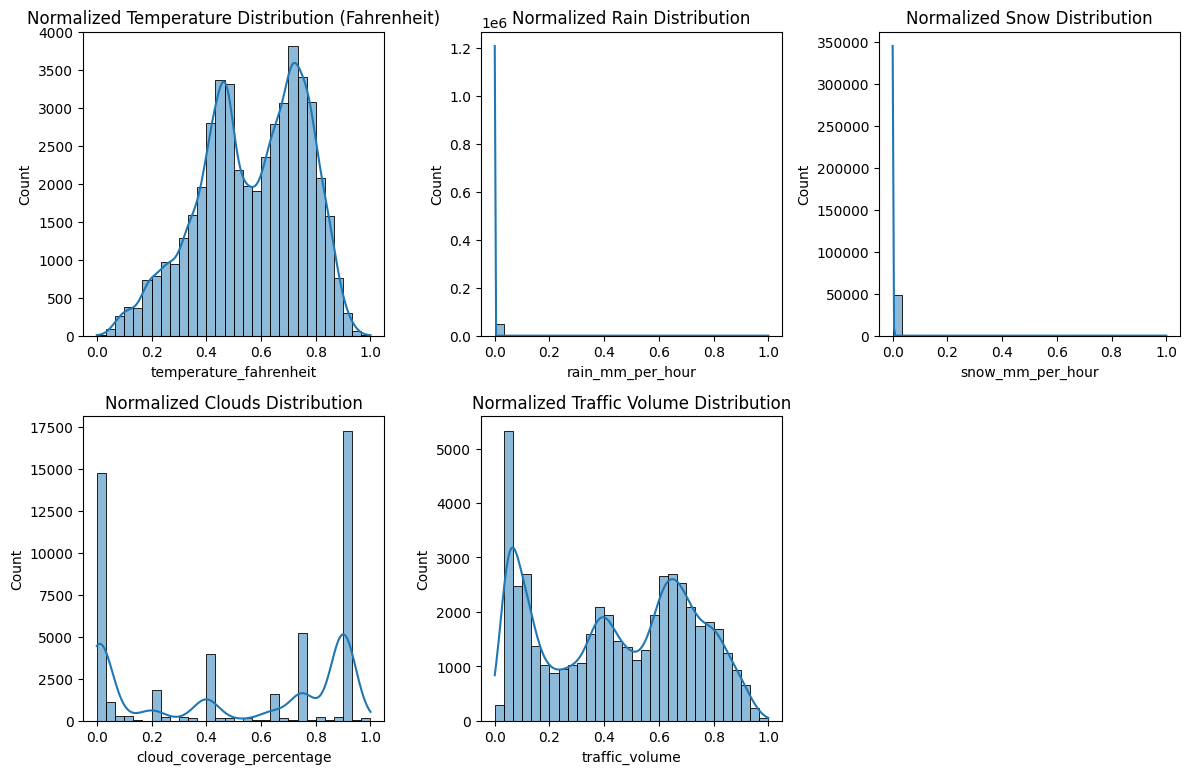

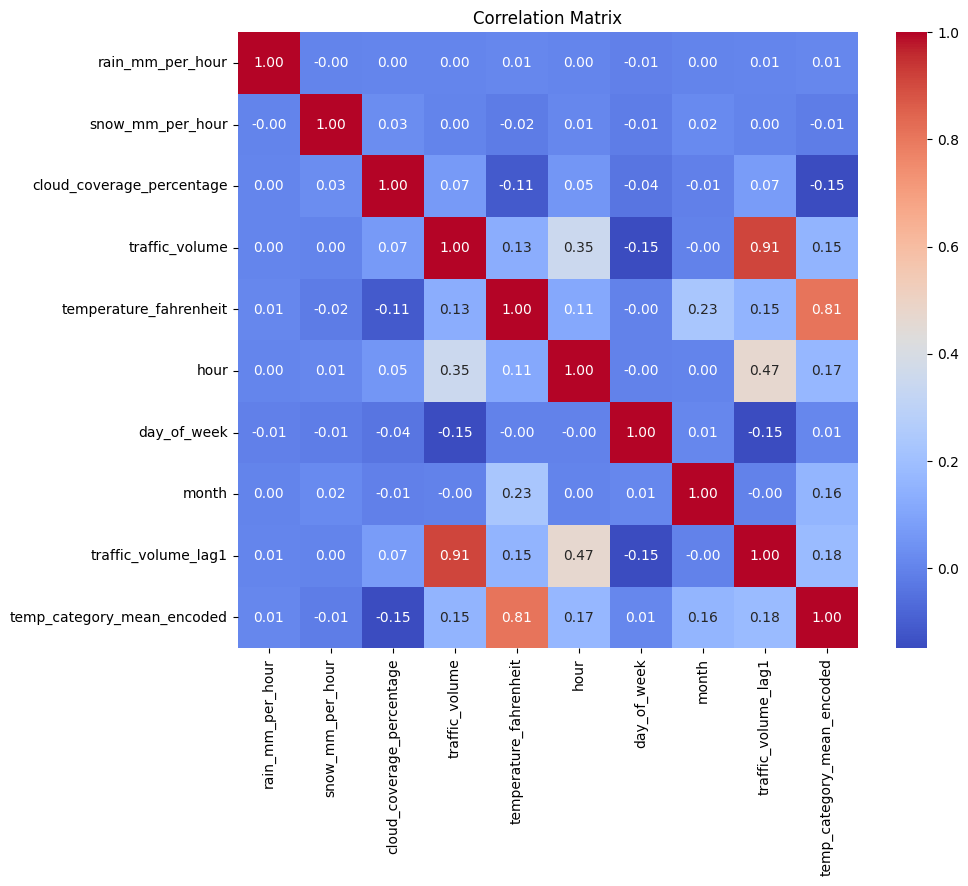

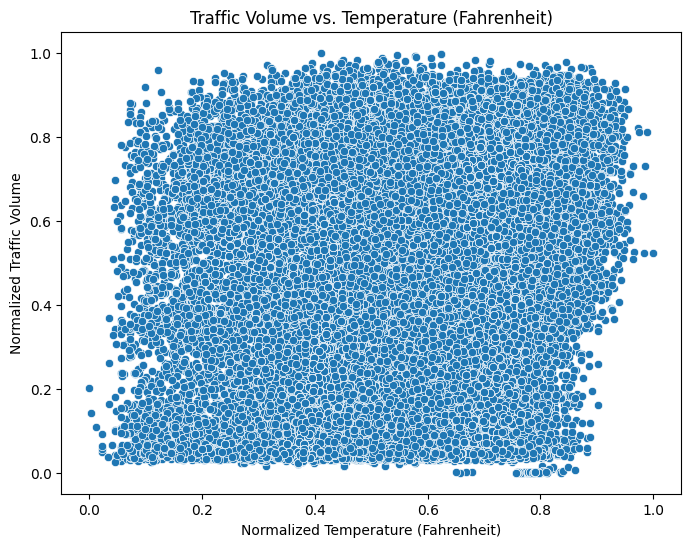

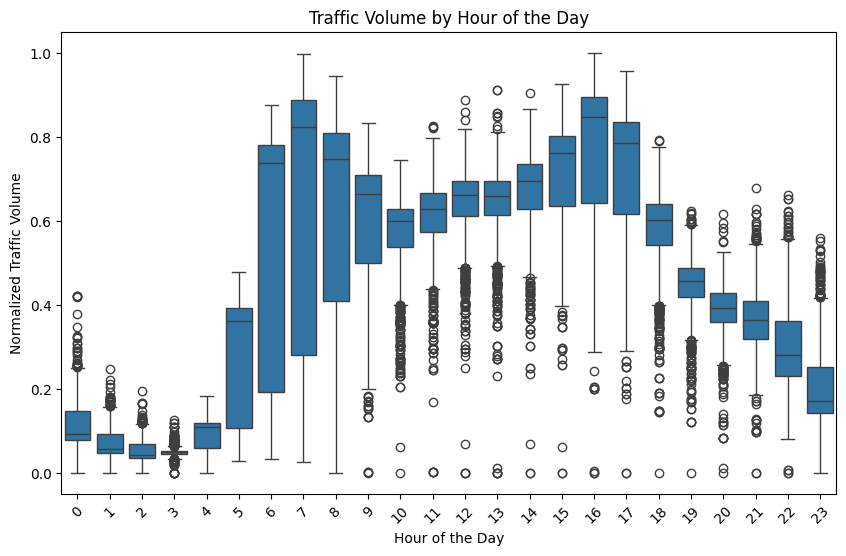

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned and normalized dataset
file_path = '/content/cleaned_data_MSAAI_Final.csv'  # Update with the correct path if needed
data = pd.read_csv(file_path)

# Convert 'date_time' back to datetime format if necessary
data['date_time'] = pd.to_datetime(data['date_time'])

# Summary statistics
print(data.describe())

# Visualizing distributions of variables
plt.figure(figsize=(12, 8))

# Temperature distribution (now using Fahrenheit)
plt.subplot(2, 3, 1)
sns.histplot(data['temperature_fahrenheit'], bins=30, kde=True)
plt.title('Normalized Temperature Distribution (Fahrenheit)')

# Rain distribution
plt.subplot(2, 3, 2)
sns.histplot(data['rain_mm_per_hour'], bins=30, kde=True)
plt.title('Normalized Rain Distribution')

# Snow distribution
plt.subplot(2, 3, 3)
sns.histplot(data['snow_mm_per_hour'], bins=30, kde=True)
plt.title('Normalized Snow Distribution')

# Clouds distribution
plt.subplot(2, 3, 4)
sns.histplot(data['cloud_coverage_percentage'], bins=30, kde=True)
plt.title('Normalized Clouds Distribution')

# Traffic Volume distribution
plt.subplot(2, 3, 5)
sns.histplot(data['traffic_volume'], bins=30, kde=True)
plt.title('Normalized Traffic Volume Distribution')

plt.tight_layout()
plt.show()

# Examining relationships using scatter plots and correlation matrices
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Optional: Scatter plot example (Traffic Volume vs. Temperature)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['temperature_fahrenheit'], y=data['traffic_volume'])
plt.title('Traffic Volume vs. Temperature (Fahrenheit)')
plt.xlabel('Normalized Temperature (Fahrenheit)')
plt.ylabel('Normalized Traffic Volume')
plt.show()

# Investigating temporal patterns (if needed, aggregate data by hour, day, month, etc.)
data['hour'] = data['date_time'].dt.hour
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='traffic_volume', data=data)
plt.title('Traffic Volume by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Traffic Volume')
plt.xticks(rotation=45)
plt.show()

In [39]:
import datetime as dt
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from random import choice, randint
import scipy.stats as scs
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, Flatten, TimeDistributed, MaxPooling1D, Activation
from tensorflow.keras.models import Sequential
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [40]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.utils import pad_sequences

In [41]:

#loading data into pandas dataframe
df = pd.read_csv('/content/cleaned_data_MSAAI_Final.csv')

#training and validation sets
# assigning size for data subset
subset_size = int(len(df)*0.01)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

In [42]:
#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [43]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['traffic_volume', 'temperature_fahrenheit']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)

    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'traffic_volume']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

In [44]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [45]:
seq_arrays.shape

(350, 30, 2)

In [46]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=30, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=15,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 30)            3960      
                                                                 
 dropout_4 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 15)                2760      
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 6736 (26.31 KB)
Trainable params: 6736 (

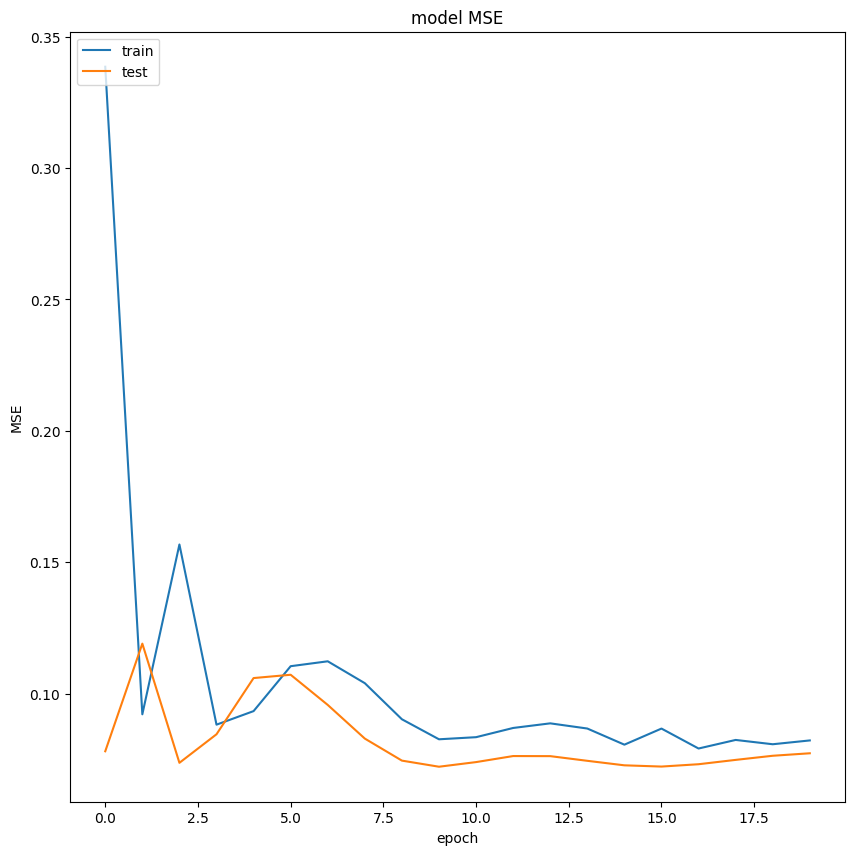

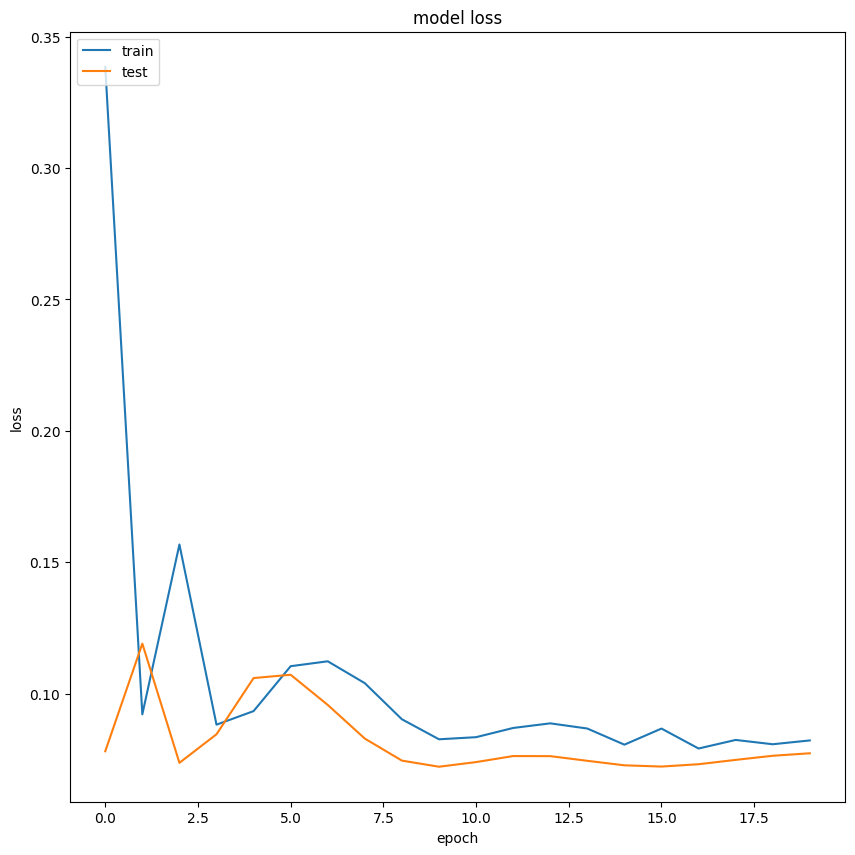

In [47]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [48]:
val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].to_numpy()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['traffic_volume'])

# use the pad_sequences function on your input sequences
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='post', truncating='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [49]:
print(val_arrays.shape)

(61, 30, 2)


2/2 - 0s - loss: 0.0686 - mse: 0.0686 - 105ms/epoch - 53ms/step

MSE: 0.06860344856977463
2/2 [==============================] - 2s 16ms/step


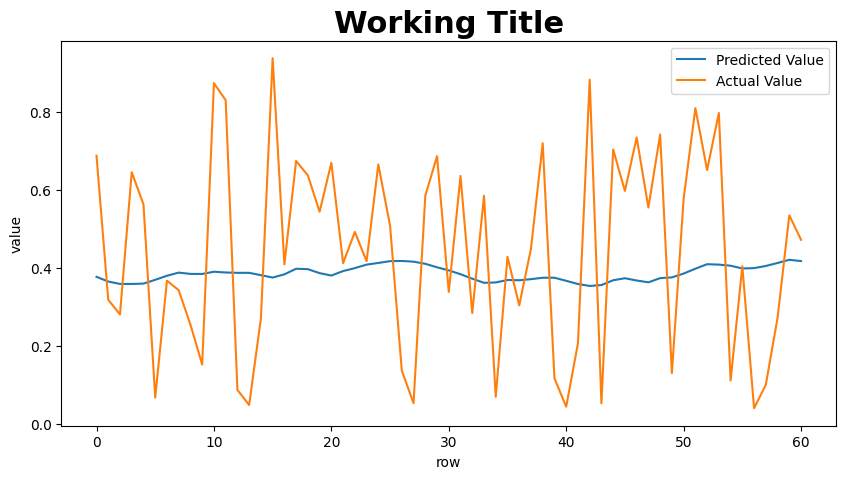

In [50]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Working Title', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [51]:
#Data loading data
df = pd.read_csv('/content/cleaned_data_MSAAI_Final.csv')

####### training and validation sets #########
# assigning size for data subset
subset_size = int(len(df)*0.04)

# taking random data subset
df_subset = df.sample(subset_size, random_state=1)

#spliting data subset 80/20 for train/validation
train_df = df_subset.sample(frac=0.8, random_state=1)
val_df = df_subset.drop(train_df.index)

#reseting the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [52]:
# Initialize empty lists for sequences and their corresponding labels
seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['traffic_volume']

#Create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    # Create a sequence of length seq_length
    seq = []
    for col in feat_cols:
        seq.append(train_df.loc[i-seq_length:i-1, col].values)
    seq = np.stack(seq, axis=1)
    seq_arrays.append(seq)

    # Get the corresponding label (GAP measurement at predictive horizon)
    label = train_df.loc[i+ph, 'traffic_volume']
    seq_labs.append(label)

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)


assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [53]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=30, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 30)            3840      
                                                                 
 dropout_6 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10)                1640      
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 5491 (21.45 KB)
Trainable params: 5491 (

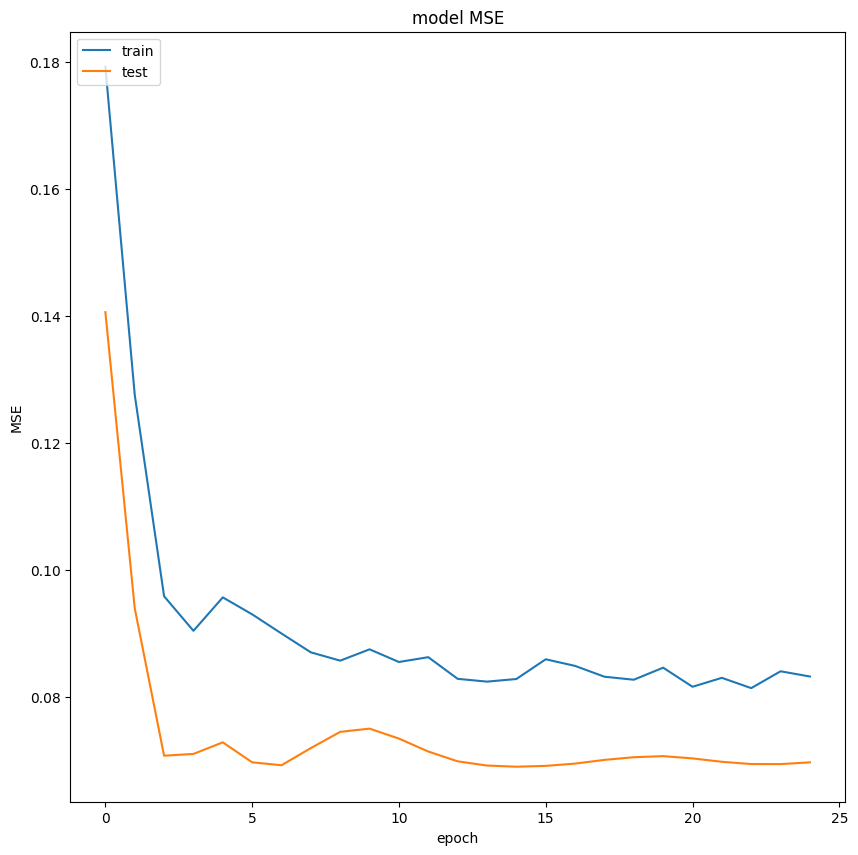

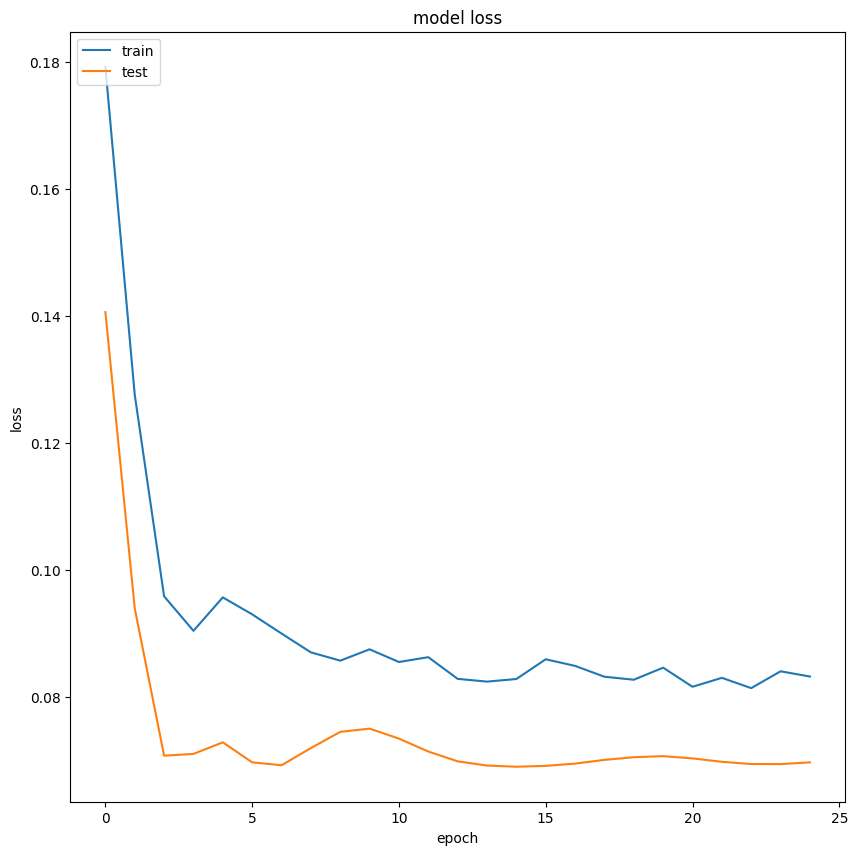

In [54]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")